In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

In [3]:
df =pd.read_csv(r'C:\Users\Lenovo\Downloads\Fraud.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
#data cleaning

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df['type'].value_counts()
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [8]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)


In [9]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [10]:
#one hot encode
df = pd.get_dummies(df, columns=['type'], drop_first=True)


In [11]:
#feature engineering
df['errorBalanceOrg'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']



In [12]:
print(df.columns.tolist())


['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'errorBalanceOrg', 'errorBalanceDest']


In [13]:
#train/test/split

from sklearn.model_selection import train_test_split

X = df.drop(['isFraud','isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [15]:
#training the model with random forest
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest on full dataset with imbalance handling
model = RandomForestClassifier(
    n_estimators=50,      # keep trees small for speed
    random_state=42,
    class_weight='balanced',
    n_jobs=-1             # use all CPU cores
)

model.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       random_state=42)

In [16]:
#model evaluation

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      1.00      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

[[1906322       0]
 [      9    2455]]
ROC-AUC: 0.9981731034928797


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.show()


In [17]:
#logistic reg
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

log_reg = LogisticRegression(max_iter=500, class_weight='balanced', n_jobs=-1)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))


=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906322
           1       0.03      0.92      0.06      2464

    accuracy                           0.96   1908786
   macro avg       0.51      0.94      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786

[[1832991   73331]
 [    208    2256]]
ROC-AUC: 0.9852189022322743


In [18]:
y_pred_rf = model.predict(X_test)

print("=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


=== Random Forest Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      1.00      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

[[1906322       0]
 [      9    2455]]
ROC-AUC: 0.9981731034928797


Top predictors of fraud:
errorBalanceOrg     0.403858
newbalanceOrig      0.143447
oldbalanceOrg       0.127543
amount              0.103530
type_PAYMENT        0.053475
type_TRANSFER       0.044989
errorBalanceDest    0.037908
step                0.031314
type_CASH_OUT       0.024573
newbalanceDest      0.018221
dtype: float64


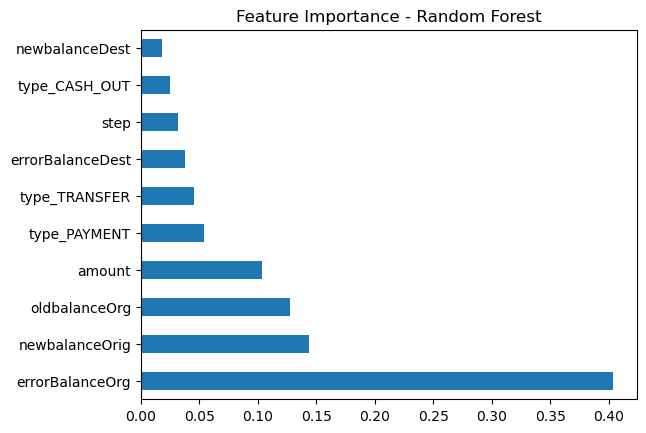

In [19]:
#feature importance (buisness insights)
import matplotlib.pyplot as plt
import pandas as pd

importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.nlargest(10)

print("Top predictors of fraud:")
print(top_features)

top_features.plot(kind='barh')
plt.title("Feature Importance - Random Forest")
plt.show()
